# Neural Texture Synthesis
## Lab session #4 2023
#### Julien.rabin (at) ensicaen.fr - 2023

![Logo](Ensicaen-logo.png)

________________________________
### LastName / Nom : 
### Surname / Prénom : 
### Group :
### Date : 
________________________________

In this notebook, the goal is to use the neural image optimization using VGG features :
- [At the beginning](#0---import--define-vgg-architecture), the (truncated) VGG-19 model (i.e. whithout the final linear layers) is defined
- [Some useful functions](#1---useful-functions) for pre & post processing images (e.g. using ImageNet statistics) and computing feature maps statistics (Gram Matrix)
- [Data loading](#2---load-vgg-model-and-images) Loads parameters for the VGG CNN and some images (a texture sample and a reference image for initialization)
- [Definition of the perceptual loss and Optimisation](#3---optimization) performs (pixel-wise) optimization of the neural network to match the texture image statistics using the perceptual loss
- [Texture Synthesis](#4---texture-synthesis-with-the-perceptual-loss)
- [Style transfer](#5---style-transfer-with-the-perceptual-loss)

________________________________
## 0 - Import & Define VGG architecture


In [11]:
%pylab inline
import time
import os 
image_dir = os.getcwd() # images are in '/Images/' and '/textures/' #
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image


import os
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print('USING CUDA ;)')
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'
    device = torch.device('cuda:0')
    # torch.cuda.current_device()
else :
    print('Using CPU :(')
    dtype = torch.FloatTensor
    device = torch.device('cpu')



Populating the interactive namespace from numpy and matplotlib
Using CPU :(


/Users/rabin/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

________________________________
## 1 - Useful functions


In [13]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [14]:
# pre and post processing for images
img_size = 256 # 512

prep = transforms.Compose([transforms.Scale(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

/Users/rabin/miniconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


________________________________
## 2 - Load VGG model and Images


### load the model

In [48]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

### load the example texture

In [49]:
# load texture image
img_name = '/textures/radishes_256.jpg'
img = Image.open(image_dir + img_name)
img_torch = prep(img).clone()
if torch.cuda.is_available():
    img_torch = Variable(img_torch.unsqueeze(0).cuda(), requires_grad=False) # [1 x 3 x N x N]
else:
    img_torch = Variable(img_torch.unsqueeze(0), requires_grad=False)

### load a reference image

In [50]:
# load an image
img_name = '/Images/boardwalk_1024.jpg' 
img0 = Image.open(image_dir + img_name)
img_torch0 = prep(img0).clone()
if torch.cuda.is_available():
    img_torch0 = Variable(img_torch0.unsqueeze(0).cuda(), requires_grad=False)
else:
    img_torch0 = Variable(img_torch0.unsqueeze(0), requires_grad=False)

### generate a random image (white gaussian noise) 

In [51]:
#random init
rdm_img = Variable(255.*torch.randn(img_torch.size()).type_as(img_torch.data)) # [1 x 3 x N x N]

example texture and initialisations (random, true image)


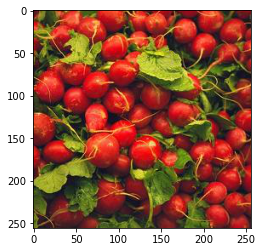

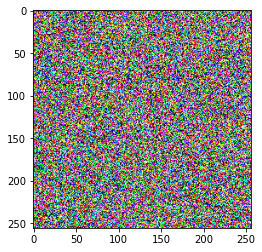

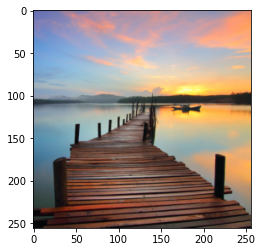

In [53]:
#display images
print("example texture and initialisations (random, true image)")
for img in [img_torch, rdm_img, img_torch0]:
    x = postp(img.clone().data[0].cpu().squeeze())
    imshow(x)
    show()

________________________________
## 3 - optimization


### Perceputal loss for image optimization

In [54]:
#define layers, loss functions, weights and compute optimization targets

texture_layers = ['r51','r54'] #['r11','r21','r31','r41','r51'] 
texture_losses = [nn.MSELoss()] * len(texture_layers)
if torch.cuda.is_available():
    texture_losses = [loss.cuda() for loss in texture_losses]
    
texture_weights = [1., 1.] # both feature maps are treated the same
#these are appropriate normalization weights for multiple layers: [1e3/n**2 for n in [64,128,256,512,512]]

#compute optimization targets
texture_Feat = [A.detach() for A in vgg(img_torch, texture_layers)]

### initialization

In [55]:
if True : # start from a reference image
    opt_img = Variable(torch.tensor(img_torch0.detach().clone()), requires_grad=True) 
else : # random init
    opt_img = Variable(torch.randn(img_torch.size()).type_as(img_torch.data), requires_grad=True) 

/Users/rabin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


### optimisation of the input image using the perceptual loss with the textural image

Iteration: 10, loss: 22716.591797


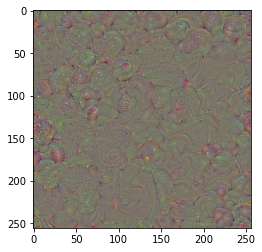

Iteration: 20, loss: 17891.882812


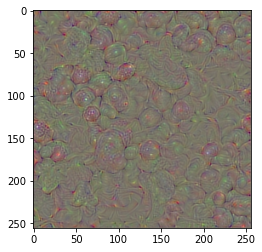

Iteration: 30, loss: 17527.486328


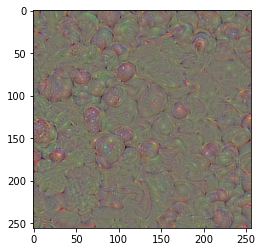

Iteration: 40, loss: 18098.261719


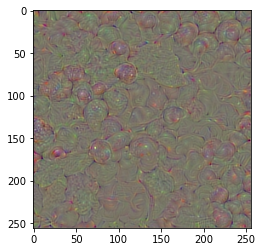

Iteration: 50, loss: 17434.613281


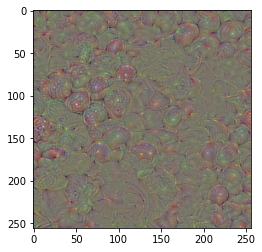

Iteration: 60, loss: 18062.148438


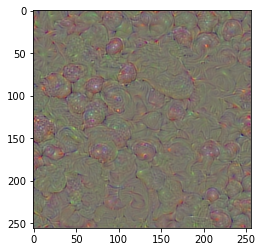

Iteration: 70, loss: 17295.355469


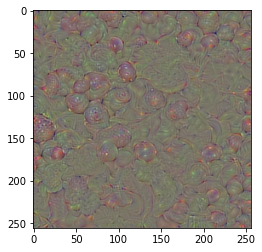

Iteration: 80, loss: 17489.642578


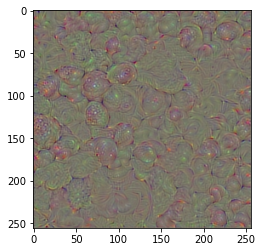

Iteration: 90, loss: 17396.580078


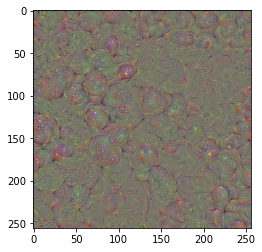

Iteration: 100, loss: 16610.300781


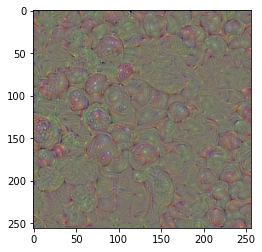

In [59]:
# optimizer
optimizer = optim.SGD([opt_img], lr = 100.)

# parameters
max_iter = 100
show_iter = 10
n_iter=[0]

# optim
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, texture_layers)
        layer_losses = [texture_weights[layer] * texture_losses[layer](Feat, texture_Feat[layer]) for layer,Feat in enumerate(out)]
        
        # loss = sum(layer_losses) # not compatible with torch 2.X
        loss = 0.
        for l in layer_losses :
            loss += l
        loss.backward()
        n_iter[0]+=1
        
        #print loss & show synthesis
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

            # display using PIL
            out_img = postp(opt_img.data[0].cpu().squeeze())
            imshow(out_img)
            show()
        
        return loss
    
    optimizer.step(closure)
    

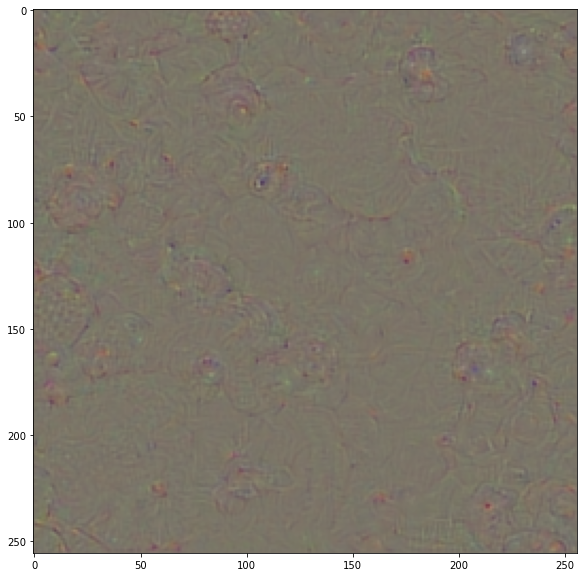

In [60]:
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)

### Questions

- plot the objective loss function during optimization
- what is the role of the initialization ? what is the difference between starting from a random and a natural image ?
- try different optimizers (SGD, Adam, LBFGS ...) and find appropriate learning rate for each. Why does LBFGS perform the best ?
- explain why some high frequency artefacts are noticeable when optimizing the input of the network; do you notice some difference with `pool == 'avg'` when loading the VGG model ? 
- change `img_size` to $512$ (if your GPU VRAM can handle it !) : how the results are different ? (consider the scale of features being synthesized)
- use only one layer to compute the loss function and compare the synthesis when using different layers : what do you conclude on the role of each layer ?
- change the number of layers and the weights corresponding to each layers so that features at each scale of the CNN are used (e.g. before each pooling layer)


________________________________
## 4 - texture synthesis with the perceptual loss



- change the loss function to compute MSE between GRAM matrices rather than Feature maps (use `GramMSELoss()` and `GramMatrix()` functions)
- what do you notice about spatial information when using Gram matrices to synthesize an image ? consider using different random initialization
- what happens with a non-textural image ?
- (if not done previously) change the 'texture_weight' factors to understand what are the role of each layer

- load another classification model (for instance inception v3 from pytorch ) and try optimizing the output using features from different layers

- what happens when optimising the spatial mean of feature maps rather than the Gram matrix ?
- Modify the loss function to compute Covariance matrices rather than Gram matrices

________________________________
## 5 - style transfer with the perceptual loss


- adapt the objective loss in the previous algorithm to preserve deep feature maps from the reference image